# Topic Modelling

Last section we've learned how to use sentence-transformer models and dimentionality reduction techniques to grasp at "text similarity" between sagas.

This section we are going to expand on this concept by introducing the topic modelling to the analyis.

In the words of Dimo & Diana, on the paper **Topic Modelling: Contextual Token Embeddings Are All you Need**. [Check it out here!](https://aclanthology.org/2024.findings-emnlp.790.ponepiecedata_by_saga)

    The goal of topic modelling is to find meaningful topics that capture the information present in a collection of documents.

While reading it's paper I really felt the need to apply it here! Let's investigate the underlying topics of One Piece! 

**Note: I'll avoid getting too much technical on this section. I'll try my best to explain what is being done on the paper quoted above and provide a clear result, but to clearly understand you should try it yourself.**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler

import hdbscan
import umap.umap_ as umap

from top2vec import Top2Vec

onepiecedata = pd.read_parquet("../outputs/volume.parquet")
onepiecedata.head(10)

,volume,text,saga,saga_expanded
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town
2,3,could they have finished with him already. he ...,East Blue,Orange Town
3,4,your swords. before we fight id better. they c...,East Blue,Syrup Village
4,5,hes the cannon man. brother they say. captured...,East Blue,Baratie
5,6,better take it easy. whos krieg. then fight me...,East Blue,Baratie
6,7,ha you can tell youre a green horn. b bones. p...,East Blue,Baratie
7,8,hatchan hachi arlongs first mate. if some thin...,East Blue,Arlong Park
8,9,having seen the strong hold of this pirate. go...,East Blue,Arlong Park
9,10,is the maximum you can hold you have no chance...,East Blue,Arlong Park


## Getting Started With Contextual Top2Vec

Quick recap of the article on how the model works:

1. Create contextualized token embeddings for each document. (We've done that, but at a sentence level, we will do that at a document level!)
2. Generate multi vector representations for the ith document. (Generate contextualized vectors by using a sliding fixed-sized window)
3. Find dense areas inside these vector representations using UMAP and HDBSCAN.
4. Apply hierarchical topic reduction.
5. Assign topics at a token level and label them by selecting the most similar phrases based on cosine similarity to the
topic vector.

And now we apply it!

In [2]:
onepiecedata.head()

,volume,text,saga,saga_expanded
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town
2,3,could they have finished with him already. he ...,East Blue,Orange Town
3,4,your swords. before we fight id better. they c...,East Blue,Syrup Village
4,5,hes the cannon man. brother they say. captured...,East Blue,Baratie


In [3]:
onepiecedata_by_saga = onepiecedata.groupby("saga")["text"].apply(lambda x: ". ".join(x)).reset_index()
onepiecedata_by_saga

,saga,text
0,Alabasta,here we go. theyre not monsters theyre welcomi...
1,Amazon Lily,their clothes are thrown into a bubbling caudr...
2,Dressrosa,but we call bla. where do you get that power. ...
3,East Blue,why dont you do it youra self. you dont have t...
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...
5,Fish-Man Island,you guys look more like men now. th thats . ca...
6,Impel Down,are you serious we dont know anything about hi...
7,Marineford,what happ pened. it froze. shut your trap pup....
8,Post-War,i didnt think the navy would be here. listen t...
9,Punk Hazard,wo ho ho ho ho ho ho ho ho ho ho ho ho ho ho h...


In [4]:
top2vec_model = Top2Vec(documents=onepiecedata_by_saga["text"].to_list(),
                        embedding_model="all-MiniLM-L6-v2",
                        topic_merge_delta=0.2,
                        speed="deep-learn", 
                        gpu_umap=True,
                        gpu_hdbscan=True,
                        contextual_top2vec=True)

2025-04-12 15:26:46,458 - top2vec - INFO - Pre-processing documents for training
/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-12 15:26:47,839 - top2vec - INFO - Creating vocabulary embedding
amdgpu.ids: No such file or directory
Embedding vocabulary:   0%|          | 0/53 [00:00<?, ?it/s]/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)
Embedding vocabulary: 100%|██████████| 53/53 [00:08<00:00,  6.34it/s]
2025-04-12 15:26:57,692 - top2vec - INFO - Create contextualized document embeddings
Embedding documents: 100%|██████████| 1/1 [00:00<00:00,  1.4

We can use the `get_document_topic_distribution()` method to get topic distribution for each saga.

In [5]:
print(top2vec_model.get_document_topic_distribution())

[[0.37890625 0.296875   0.32421875]
 [0.39648438 0.296875   0.30664062]
 [0.359375   0.32421875 0.31640625]
 [0.38085938 0.3125     0.30664062]
 [0.33789062 0.35351562 0.30859375]
 [0.36328125 0.3359375  0.30078125]
 [0.375      0.30664062 0.31835938]
 [0.33398438 0.37304688 0.29296875]
 [0.375      0.34765625 0.27734375]
 [0.3359375  0.359375   0.3046875 ]
 [0.45507812 0.3203125  0.22460938]
 [0.37695312 0.33203125 0.29101562]
 [0.42382812 0.2421875  0.33398438]
 [0.34570312 0.34765625 0.30664062]
 [0.33203125 0.37109375 0.296875  ]
 [0.33984375 0.34960938 0.31054688]
 [0.35546875 0.33789062 0.30664062]]


In [6]:
topics_by_saga = pd.DataFrame(top2vec_model.get_document_topic_distribution(), columns=["Topic_1", "Topic_2", "Topic_3"])
onepiecedata_by_saga = pd.concat([
    onepiecedata_by_saga,
    topics_by_saga
], axis=1)
onepiecedata_by_saga.head()

,saga,text,Topic_1,Topic_2,Topic_3
0,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219
1,Amazon Lily,their clothes are thrown into a bubbling caudr...,0.396484,0.296875,0.306641
2,Dressrosa,but we call bla. where do you get that power. ...,0.359375,0.324219,0.316406
3,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594


Now let's look at some common words by topic.

In [7]:
topic_1_words, topic_2_words, topic_3_words = top2vec_model.get_topics()[0]
topic_1_freq, topic_2_freq, topic_3_freq = top2vec_model.get_topics()[1]
print(topic_1_words, "\n" ,topic_2_words, "\n", topic_3_words)

['fate' 'pirates' 'naval' 'luffy' 'sea' 'luffys' 'mercy' 'duty' 'marine'
 'navy' 'die' 'navys' 'defeat' 'galleyla' 'captured' 'chapter' 'soul'
 'seas' 'killing' 'fleet' 'line' 'battle' 'nam' 'chief' 'shore' 'general'
 'direction' 'song' 'passage' 'fortune' 'words' 'thinking' 'thought'
 'side' 'boss' 'death' 'war' 'mighty' 'lost' 'about' 'fighting' 'sabo'
 'islands' 'deep' 'kill' 'imagine' 'poison' 'force' 'life' 'flame'] 
 ['pirates' 'fate' 'luffys' 'onigashima' 'luffy' 'duty' 'marine' 'escaped'
 'naval' 'kill' 'warlord' 'killing' 'nam' 'captured' 'warlords' 'battle'
 'kingdom' 'mercy' 'trapped' 'escape' 'navy' 'poison' 'commander'
 'kanjuro' 'dying' 'sanji' 'warden' 'captains' 'nami' 'navys' 'gumgum'
 'defeat' 'fire' 'shirahoshi' 'enemy' 'sanjis' 'flame' 'shogun' 'namis'
 'chief' 'burning' 'mermaid' 'galleyla' 'destroy' 'kaido' 'kaidos'
 'kinemon' 'seas' 'riku' 'meow'] 
 ['pirates' 'killing' 'fate' 'kill' 'duty' 'mercy' 'defeat' 'dying'
 'marine' 'navy' 'luffy' 'pirate' 'commander' 'n

It's better to use wordclouds!

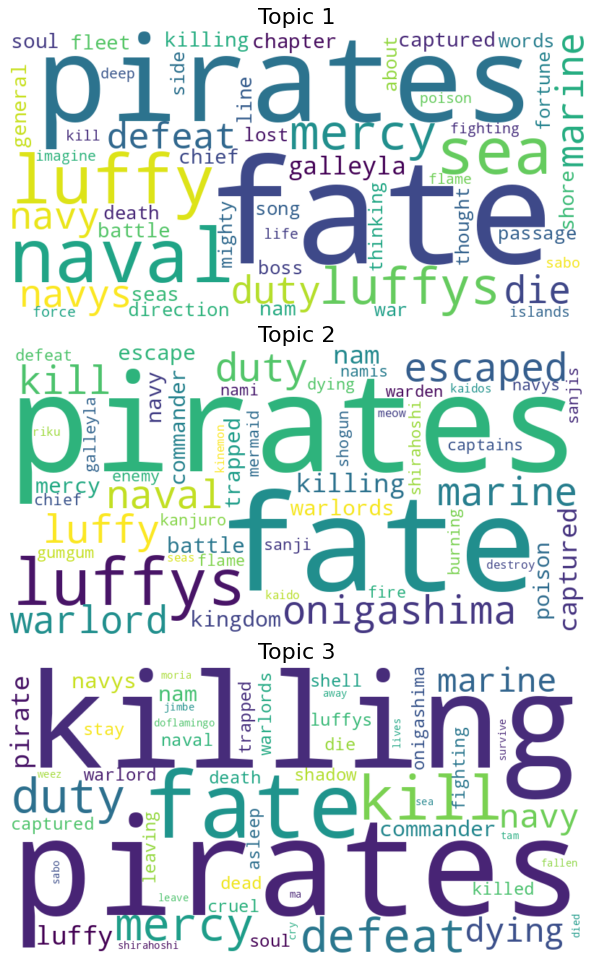

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(25, 15), dpi=80)
fig.subplots_adjust(hspace=0.1)

# First word cloud
frequencies = {word: size for word, size in zip(topic_1_words, topic_1_freq)}

wordcloud_1 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

axes[0].imshow(wordcloud_1, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Topic 1", fontsize=20)

frequencies = {word: size for word, size in zip(topic_2_words, topic_2_freq)}
wordcloud_2 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

axes[1].imshow(wordcloud_2, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Topic 2", fontsize=20)

frequencies = {word: size for word, size in zip(topic_3_words, topic_3_freq)}
wordcloud_3 = WordCloud(
    width=400,
    height=200,
    scale=2,
    max_font_size=100,
    background_color="white"
).generate_from_frequencies(frequencies=frequencies)

axes[2].imshow(wordcloud_3, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("Topic 3", fontsize=20)

plt.show()

There is still a lot of intersection between those topics, but the underlying topic among them all seem to be the same: pirates! (What a surprise!)

This may seem pretty basic, but note that I've done absolutely nothing to label the transcripts and we can infer the underlying topics it deals with.

Some common topics are: pirates, fate, duty, destiny, sea, navy, brothers, battle, escape...

Now that we have a way of differencing sagas by topics, we can visualize it just as before! But this time, distances will be more considerate of the context in each saga.

In [9]:
fit = umap.UMAP(
    n_neighbors=15,
    metric="euclidean",
    init="pca",
    n_components=2
).fit(onepiecedata_by_saga[["Topic_1", "Topic_2", "Topic_3"]])
umap_embedding = fit.embedding_

oneonepiecedata_by_saga_visual = pd.DataFrame({"X":umap_embedding[:, 0], "Y":umap_embedding[:, 1], "saga":onepiecedata_by_saga["saga"]})
oneonepiecedata_by_saga_visual.head()

/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,saga
0,1.326891,21.715216,Alabasta
1,0.596436,21.147430,Amazon Lily
2,0.160142,22.902077,Dressrosa
3,0.695940,21.706226,East Blue
4,0.653831,24.454453,Enies Lobby


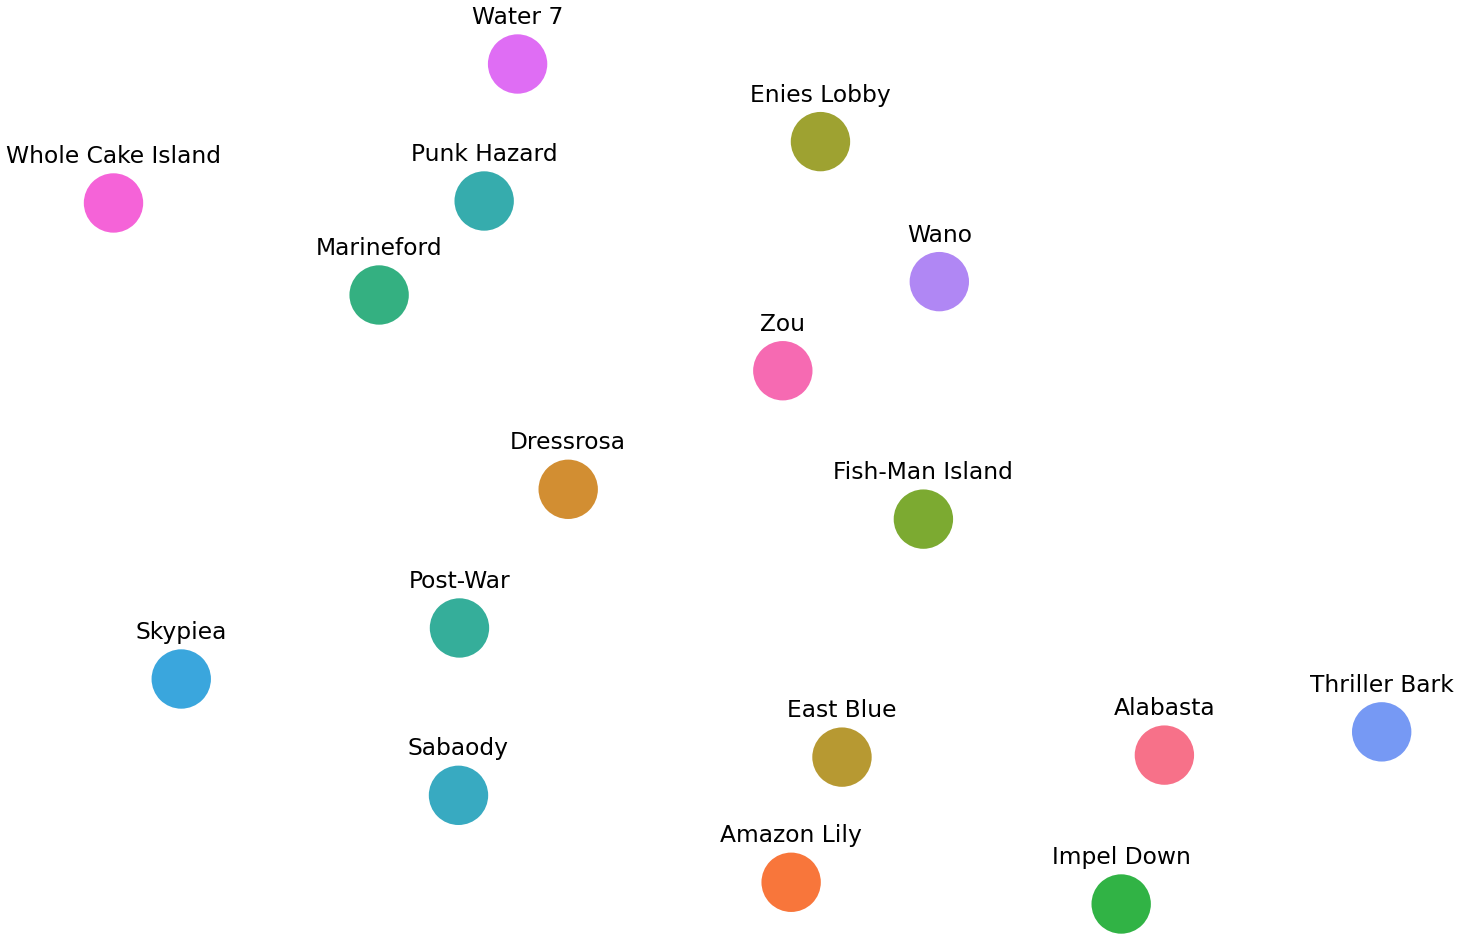

In [10]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=60)
sns.scatterplot(x="X", y="Y", data=oneonepiecedata_by_saga_visual, hue="saga", s=6000)  # alpha=0 remove os pontos

# Adicionar os textos ao invés dos pontos
for _, row in oneonepiecedata_by_saga_visual.iterrows():
    plt.text(row["X"], row["Y"] + 0.21, row["saga"], fontsize=28, ha='center', va='center')

# Remover a legenda
plt.legend([], [], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
# ax.set_title("Phrase Differences by Saga", pad=20, fontsize=25)
plt.show()

The fact we see Marineford, Enies Lobby and Water 7 so close to each other is a huge factor on how well contextual embeddings are capable of understanding topics!

Another thing we can do is make sense of this visual ourselves! For example:

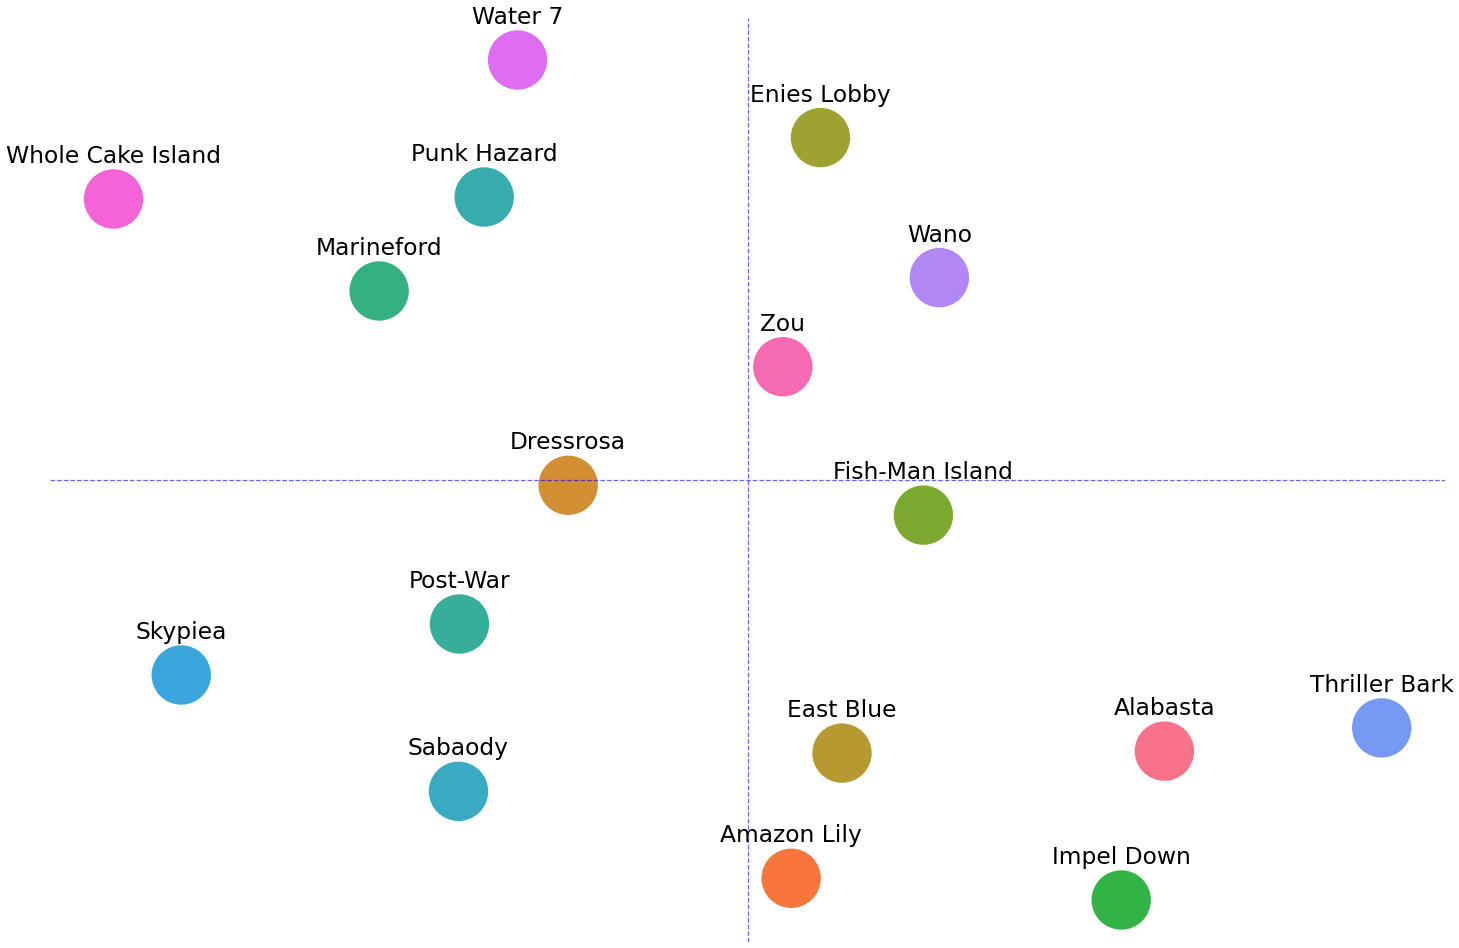

In [11]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=60)
sns.scatterplot(x="X", y="Y", data=oneonepiecedata_by_saga_visual, hue="saga", s=6000)  # alpha=0 remove os pontos

# Adicionar os textos ao invés dos pontos
for _, row in oneonepiecedata_by_saga_visual.iterrows():
    plt.text(row["X"], row["Y"] + 0.19, row["saga"], fontsize=28, ha='center', va='center')

x_min, x_max = oneonepiecedata_by_saga_visual["X"].min(), oneonepiecedata_by_saga_visual["X"].max()
y_min, y_max = oneonepiecedata_by_saga_visual["Y"].min(), oneonepiecedata_by_saga_visual["Y"].max()
x_mid = (x_min + x_max) / 2
y_mid = (y_min + y_max) / 2

ax.axvline(x=x_mid, color='blue', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axhline(y=y_mid, color='blue', linestyle='--', linewidth=1.5, alpha=0.6)

# Remover a legenda
plt.legend([], [], frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
# ax.set_title("Phrase Differences by Saga", pad=20, fontsize=25)
plt.show()



And that is a clear way of visualizing topic distances between One Piece Sagas! But there is still one more thing to do before closing this "topic": evolution of topics during the production of the manga! 

To be fair, this was not planned in the beggining, but a comment on my linkedin post (potuguese) on this topic made me wanna see the result! If you wish to see it it's [here](https://www.linkedin.com/posts/kaiusdepaula_nlpiece-topic-modelling-activity-7310994007734599680-s1UW?utm_source=share&utm_medium=member_desktop&rcm=ACoAACbD8c8B7uQkcNuo4yXNM5qcgyvHCDh-4-E).

In [12]:
onepiecedata_by_saga.head()

,saga,text,Topic_1,Topic_2,Topic_3
0,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219
1,Amazon Lily,their clothes are thrown into a bubbling caudr...,0.396484,0.296875,0.306641
2,Dressrosa,but we call bla. where do you get that power. ...,0.359375,0.324219,0.316406
3,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594


Let me create a ordering column here first.

In [13]:
print(f"This is the column order: \n{onepiecedata.saga.unique()}")

This is the column order: 
['East Blue' 'Alabasta' 'Skypiea' 'Water 7' 'Enies Lobby' 'Thriller Bark'
 'Sabaody' 'Amazon Lily' 'Impel Down' 'Marineford' 'Post-War'
 'Fish-Man Island' 'Punk Hazard' 'Dressrosa' 'Zou' 'Whole Cake Island'
 'Wano']


In [14]:
sagas_ordered = pd.DataFrame(zip(onepiecedata.saga.unique(), range(len(onepiecedata.saga.unique()))), columns=["saga", "order"])
sagas_ordered

,saga,order
0,East Blue,0
1,Alabasta,1
2,Skypiea,2
3,Water 7,3
4,Enies Lobby,4
5,Thriller Bark,5
6,Sabaody,6
7,Amazon Lily,7
8,Impel Down,8
9,Marineford,9


In [15]:
onepiecedata_by_saga = pd.merge(
    onepiecedata_by_saga,
    sagas_ordered,
    on="saga",
    how="left"
)
onepiecedata_by_saga = onepiecedata_by_saga.sort_values("order")
onepiecedata_by_saga

,saga,text,Topic_1,Topic_2,Topic_3,order
3,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641,0
0,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219,1
11,Skypiea,blup blup. i thought you were after my gold. w...,0.376953,0.332031,0.291016,2
14,Water 7,what happ pened. could this be. rolling explod...,0.332031,0.371094,0.296875,3
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594,4
12,Thriller Bark,the strange creatures of this forest. i am rat...,0.423828,0.242188,0.333984,5
10,Sabaody,if we keep losing warlords one after another i...,0.455078,0.320312,0.224609,6
1,Amazon Lily,their clothes are thrown into a bubbling caudr...,0.396484,0.296875,0.306641,7
6,Impel Down,are you serious we dont know anything about hi...,0.375000,0.306641,0.318359,8
7,Marineford,what happ pened. it froze. shut your trap pup....,0.333984,0.373047,0.292969,9


And now one thing I think will provide a clear visualization is to manually remove inconsistencies on word topics and differentiate them by the set differences.

In [16]:
print(topic_1_words,"\n", topic_2_words,"\n", topic_3_words)

['fate' 'pirates' 'naval' 'luffy' 'sea' 'luffys' 'mercy' 'duty' 'marine'
 'navy' 'die' 'navys' 'defeat' 'galleyla' 'captured' 'chapter' 'soul'
 'seas' 'killing' 'fleet' 'line' 'battle' 'nam' 'chief' 'shore' 'general'
 'direction' 'song' 'passage' 'fortune' 'words' 'thinking' 'thought'
 'side' 'boss' 'death' 'war' 'mighty' 'lost' 'about' 'fighting' 'sabo'
 'islands' 'deep' 'kill' 'imagine' 'poison' 'force' 'life' 'flame'] 
 ['pirates' 'fate' 'luffys' 'onigashima' 'luffy' 'duty' 'marine' 'escaped'
 'naval' 'kill' 'warlord' 'killing' 'nam' 'captured' 'warlords' 'battle'
 'kingdom' 'mercy' 'trapped' 'escape' 'navy' 'poison' 'commander'
 'kanjuro' 'dying' 'sanji' 'warden' 'captains' 'nami' 'navys' 'gumgum'
 'defeat' 'fire' 'shirahoshi' 'enemy' 'sanjis' 'flame' 'shogun' 'namis'
 'chief' 'burning' 'mermaid' 'galleyla' 'destroy' 'kaido' 'kaidos'
 'kinemon' 'seas' 'riku' 'meow'] 
 ['pirates' 'killing' 'fate' 'kill' 'duty' 'mercy' 'defeat' 'dying'
 'marine' 'navy' 'luffy' 'pirate' 'commander' 'n

In [17]:
set_topic_1 = set(topic_1_words)
set_topic_2 = set(topic_2_words)
set_topic_3 = set(topic_3_words)

topic_1 = set_topic_1.difference(set_topic_2).difference(set_topic_3)
topic_2 = set_topic_2.difference(set_topic_1).difference(set_topic_3)
topic_3 = set_topic_3.difference(set_topic_2).difference(set_topic_1)

print(topic_1,"\n", topic_2,"\n", topic_3)

{'force', 'lost', 'side', 'islands', 'imagine', 'fortune', 'thinking', 'about', 'mighty', 'fleet', 'passage', 'general', 'chapter', 'words', 'direction', 'boss', 'line', 'deep', 'life', 'shore', 'war', 'thought', 'song'} 
 {'gumgum', 'namis', 'fire', 'sanjis', 'escaped', 'kinemon', 'riku', 'captains', 'kaido', 'destroy', 'kanjuro', 'kingdom', 'nami', 'shogun', 'meow', 'burning', 'warden', 'mermaid', 'kaidos', 'escape', 'enemy', 'sanji'} 
 {'stay', 'ma', 'jimbe', 'survive', 'away', 'weez', 'doflamingo', 'cry', 'asleep', 'died', 'leave', 'killed', 'cruel', 'fallen', 'lives', 'shadow', 'tam', 'moria', 'shell', 'dead', 'leaving', 'pirate'}


I could manually remove the personal names from those sets, but as of it is now I'm still coming back to this notebook, and results are a bit random when it comes to tokens and topics. I'll leave them in as such.


Now it's time to define the most likely topic for each saga. That is basically done for us and we can just select the bigger result from those 3. 

In [18]:
onepiecedata_by_saga["most_relevant_topic"] = np.argmax(onepiecedata_by_saga[["Topic_1", "Topic_2", "Topic_3"]], axis=1) + 1
onepiecedata_by_saga

,saga,text,Topic_1,Topic_2,Topic_3,order,most_relevant_topic
3,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641,0,1
0,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219,1,1
11,Skypiea,blup blup. i thought you were after my gold. w...,0.376953,0.332031,0.291016,2,1
14,Water 7,what happ pened. could this be. rolling explod...,0.332031,0.371094,0.296875,3,2
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594,4,2
12,Thriller Bark,the strange creatures of this forest. i am rat...,0.423828,0.242188,0.333984,5,1
10,Sabaody,if we keep losing warlords one after another i...,0.455078,0.320312,0.224609,6,1
1,Amazon Lily,their clothes are thrown into a bubbling caudr...,0.396484,0.296875,0.306641,7,1
6,Impel Down,are you serious we dont know anything about hi...,0.375000,0.306641,0.318359,8,1
7,Marineford,what happ pened. it froze. shut your trap pup....,0.333984,0.373047,0.292969,9,2


My pal `chatgpt` came up with those topics for the specific keywords.

In [19]:
topic_labels = {
    1: "Adventure & Legacy",
    2: "Conflict & Power Struggles",
    3: "Emotions & Sacrifice"
}

onepiecedata_by_saga["topic_label"] = onepiecedata_by_saga["most_relevant_topic"].map(topic_labels)
onepiecedata_by_saga.head()

,saga,text,Topic_1,Topic_2,Topic_3,order,most_relevant_topic,topic_label
3,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641,0,1,Adventure & Legacy
0,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219,1,1,Adventure & Legacy
11,Skypiea,blup blup. i thought you were after my gold. w...,0.376953,0.332031,0.291016,2,1,Adventure & Legacy
14,Water 7,what happ pened. could this be. rolling explod...,0.332031,0.371094,0.296875,3,2,Conflict & Power Struggles
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594,4,2,Conflict & Power Struggles


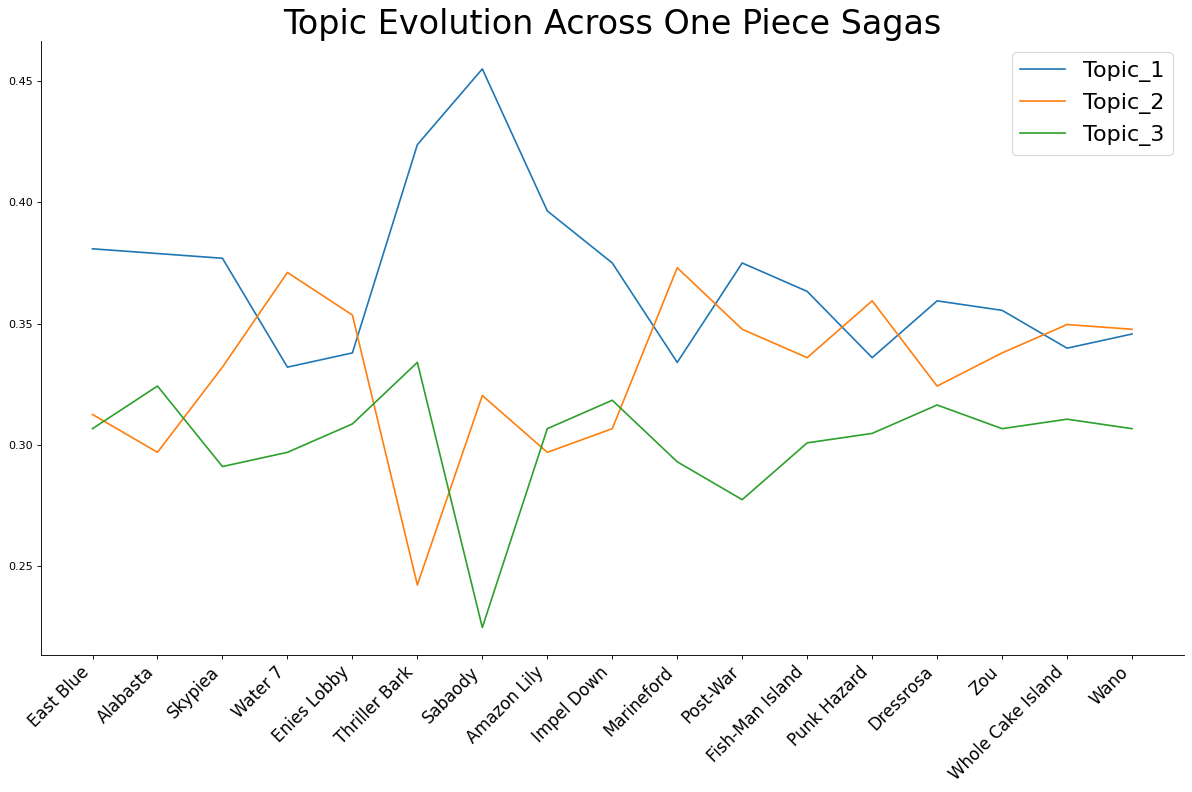

In [53]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
for topic_num in ['Topic_1', 'Topic_2', 'Topic_3']:
    plt.plot(onepiecedata_by_saga.sort_values('order')['order'], onepiecedata_by_saga.sort_values('order')[topic_num], label=topic_num)

plt.xticks(onepiecedata_by_saga['order'], onepiecedata_by_saga['saga'], rotation=45, ha='right',fontsize=15)
plt.legend(fontsize=20)
plt.title("Topic Evolution Across One Piece Sagas", fontsize=30)
plt.tight_layout()
sns.despine()
plt.show()


Looks a bit polluted aint it? Let's use the reduced form of those axis to plot again, as we have done previously.

In [21]:
onepiecedata_by_saga = pd.merge(
    onepiecedata_by_saga,
    oneonepiecedata_by_saga_visual,
    on="saga"
)

onepiecedata_by_saga.columns = ['saga', 'text', 'Topic_1', 'Topic_2', 'Topic_3', 'order',
       'most_relevant_topic', "topic_label", "Topic_1_reduced", "Topic_2_reduced"]
onepiecedata_by_saga.head()

,saga,text,Topic_1,Topic_2,Topic_3,order,most_relevant_topic,topic_label,Topic_1_reduced,Topic_2_reduced
0,East Blue,why dont you do it youra self. you dont have t...,0.380859,0.312500,0.306641,0,1,Adventure & Legacy,0.695940,21.706226
1,Alabasta,here we go. theyre not monsters theyre welcomi...,0.378906,0.296875,0.324219,1,1,Adventure & Legacy,1.326891,21.715216
2,Skypiea,blup blup. i thought you were after my gold. w...,0.376953,0.332031,0.291016,2,1,Adventure & Legacy,-0.597108,22.055069
3,Water 7,what happ pened. could this be. rolling explod...,0.332031,0.371094,0.296875,3,2,Conflict & Power Struggles,0.061101,24.801033
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,0.337891,0.353516,0.308594,4,2,Conflict & Power Struggles,0.653831,24.454453


In [34]:
scaler = StandardScaler()

# Apply scaling for both columns separately and store them back
onepiecedata_by_saga["Topic_1_reduced"] = scaler.fit_transform(onepiecedata_by_saga[["Topic_1_reduced"]])
onepiecedata_by_saga["Topic_2_reduced"] = scaler.fit_transform(onepiecedata_by_saga[["Topic_2_reduced"]])

# Display the scaled columns
onepiecedata_by_saga[["Topic_1_reduced", "Topic_2_reduced"]]


,Topic_1_reduced,Topic_2_reduced
0,0.414947,-0.912348
1,1.368320,-0.904866
2,-1.538859,-0.621974
3,-0.544299,1.663746
4,0.351321,1.375255
5,2.010860,-0.818435
6,-0.719051,-1.054298
7,0.264596,-1.377486
8,1.240565,-1.458223
9,-0.953754,0.805248


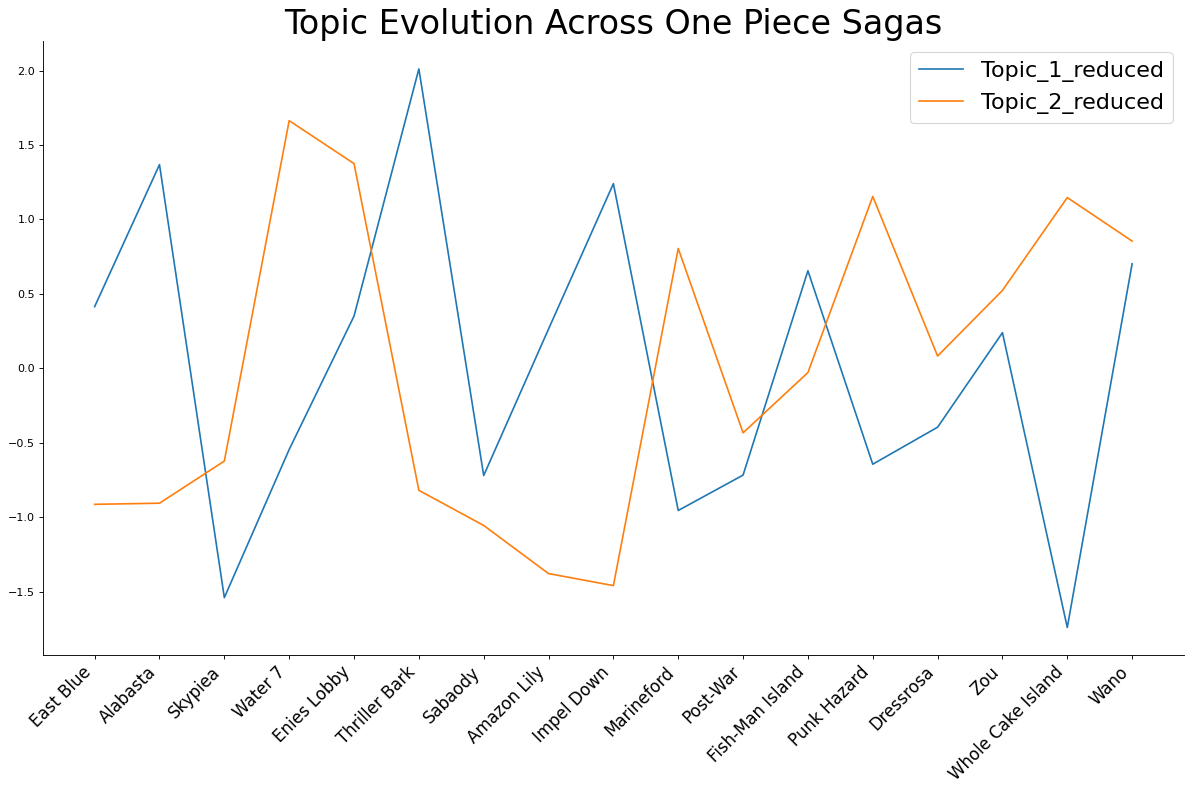

In [55]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
for topic_num in ['Topic_1_reduced', 'Topic_2_reduced']:
    plt.plot(onepiecedata_by_saga.sort_values('order')['order'], onepiecedata_by_saga.sort_values('order')[topic_num], label=topic_num)

plt.xticks(onepiecedata_by_saga['order'], onepiecedata_by_saga['saga'], rotation=45, ha='right',fontsize=15)
plt.legend(fontsize=20)
plt.title("Topic Evolution Across One Piece Sagas", fontsize=30)
plt.tight_layout()
sns.despine()
plt.show()


We can do even better by subtracting one from another. As it will be centered on zero, values above and below zero will represent change!

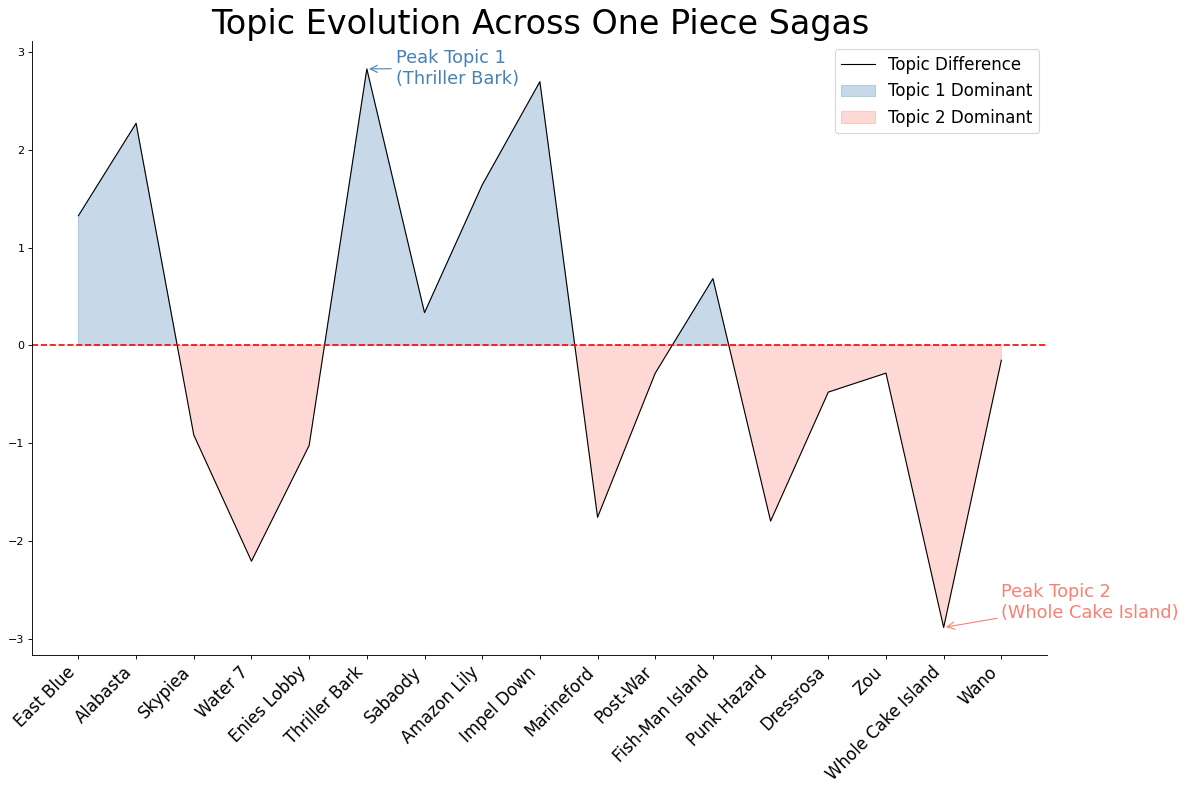

In [56]:
onepiecedata_by_saga["label_color"] = onepiecedata_by_saga["topic_label"].map(color_map)

onepiecedata_by_saga["Topic_difference"] = onepiecedata_by_saga["Topic_1_reduced"] - onepiecedata_by_saga["Topic_2_reduced"]

fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
# Plot the line showing the difference
ax.plot(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], label="Topic Difference", color="black", linewidth=1)

# Fill where Topic 1 > Topic 2
ax.fill_between(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], 0, 
                where=(onepiecedata_by_saga['Topic_difference'] > 0), interpolate=True,
                color='steelblue', alpha=0.3, label="Topic 1 Dominant")

# Fill where Topic 2 > Topic 1
ax.fill_between(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], 0, 
                where=(onepiecedata_by_saga['Topic_difference'] < 0), interpolate=True,
                color='salmon', alpha=0.3, label="Topic 2 Dominant")

# Horizontal line for neutrality
ax.axhline(y=0, linestyle="--", color="red")

# X-axis setup
plt.xticks(onepiecedata_by_saga['order'], onepiecedata_by_saga['saga'], rotation=45, ha='right', fontsize=15)
plt.title("Topic Evolution Across One Piece Sagas", fontsize=30)

# Find max and min points
max_point = onepiecedata_by_saga.loc[onepiecedata_by_saga['Topic_difference'].idxmax()]
min_point = onepiecedata_by_saga.loc[onepiecedata_by_saga['Topic_difference'].idxmin()]

# Annotate on plot
ax.annotate(f"Peak Topic 1\n({max_point['saga']})",
            xy=(max_point['order'], max_point['Topic_difference']),
            xytext=(max_point['order'] + 0.5, max_point['Topic_difference'] - 0.15),
            arrowprops=dict(arrowstyle='->', color='steelblue'),
            fontsize=16, color='steelblue')

ax.annotate(f"Peak Topic 2\n({min_point['saga']})",
            xy=(min_point['order'], min_point['Topic_difference']),
            xytext=(min_point['order'] + 1, min_point['Topic_difference'] + 0.1),
            arrowprops=dict(arrowstyle='->', color='salmon'),
            fontsize=16, color='salmon')

# Legend and layout
plt.legend(fontsize=15)
# Replace legend
plt.tight_layout()
sns.despine()
plt.show()

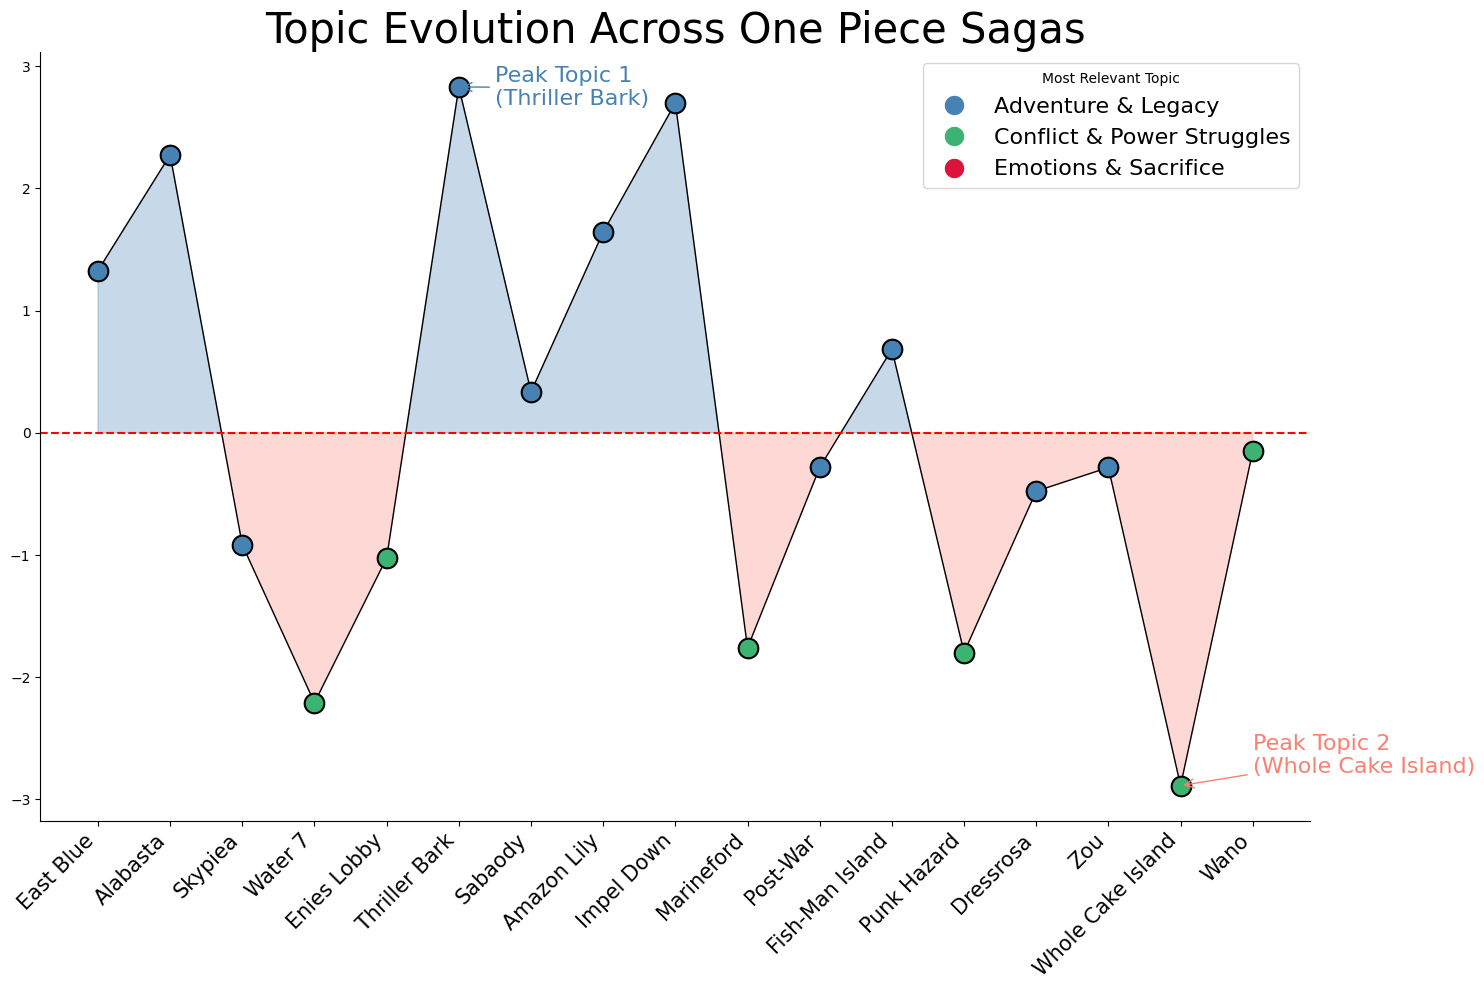

In [57]:
# Color map for topics
color_map = {
    "Adventure & Legacy": "steelblue",
    "Conflict & Power Struggles": "mediumseagreen",
    "Emotions & Sacrifice": "crimson"
}

# Assign colors based on topic labels
onepiecedata_by_saga["label_color"] = onepiecedata_by_saga["topic_label"].map(color_map)

# Ensure no missing values or invalid types
onepiecedata_by_saga = onepiecedata_by_saga.dropna(subset=["order", "Topic_difference", "saga"])

# Calculate the topic difference
onepiecedata_by_saga["Topic_difference"] = onepiecedata_by_saga["Topic_1_reduced"] - onepiecedata_by_saga["Topic_2_reduced"]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Plot the line showing the topic difference
ax.plot(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], label="Topic Difference", color="black", linewidth=1)

# Fill where Topic 1 is dominant
ax.fill_between(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], 0, 
                where=(onepiecedata_by_saga['Topic_difference'] > 0), interpolate=True,
                color='steelblue', alpha=0.3, label="Topic 1 Dominant")

# Fill where Topic 2 is dominant
ax.fill_between(onepiecedata_by_saga['order'], onepiecedata_by_saga['Topic_difference'], 0, 
                where=(onepiecedata_by_saga['Topic_difference'] < 0), interpolate=True,
                color='salmon', alpha=0.3, label="Topic 2 Dominant")

# Horizontal line for neutrality
ax.axhline(y=0, linestyle="--", color="red")

# Overlay colored circles for each saga
for _, row in onepiecedata_by_saga.iterrows():
    # Check if the 'order' and 'Topic_difference' are numeric
    if isinstance(row["order"], (int, float)) and isinstance(row["Topic_difference"], (int, float)):
        ax.scatter(
            row["order"],
            row["Topic_difference"],
            color=row["label_color"],
            s=200,
            edgecolor="black",
            linewidth=1.5,
            zorder=3
        )

# Find max and min points for peak annotations
max_point = onepiecedata_by_saga.loc[onepiecedata_by_saga['Topic_difference'].idxmax()]
min_point = onepiecedata_by_saga.loc[onepiecedata_by_saga['Topic_difference'].idxmin()]

# Annotate peaks
ax.annotate(f"Peak Topic 1\n({max_point['saga']})",
            xy=(max_point['order'], max_point['Topic_difference']),
            xytext=(max_point['order'] + 0.5, max_point['Topic_difference'] - 0.15),
            arrowprops=dict(arrowstyle='->', color='steelblue'),
            fontsize=16, color='steelblue')

ax.annotate(f"Peak Topic 2\n({min_point['saga']})",
            xy=(min_point['order'], min_point['Topic_difference']),
            xytext=(min_point['order'] + 1, min_point['Topic_difference'] + 0.1),
            arrowprops=dict(arrowstyle='->', color='salmon'),
            fontsize=16, color='salmon')

# Set up the X-axis
plt.xticks(onepiecedata_by_saga['order'], onepiecedata_by_saga['saga'], rotation=45, ha='right', fontsize=15)
plt.title("Topic Evolution Across One Piece Sagas", fontsize=30)

# Add custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=15)
    for label, color in color_map.items()
]

plt.legend(handles=legend_elements, title="Most Relevant Topic", loc="upper right", fontsize=16)

# Tight layout and remove axis spines
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()


And now we achieved PEAK fiction! That's all for topic modelling! I hope you enjoyed this so far and I'll see you on `GettingEmotional.ipynb`.